In [1]:
import pandas as pd
import requests
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import RocCurveDisplay
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score, make_scorer,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score,accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import tree,metrics
import sklearn

In [21]:
#Global Values

#resale fp
RSF_fp="Relevant_datasets/RSF90onw_wAddress.csv"

#visualization output file path
plots_filepaths="Relevant_datasets/2_C/"

In [23]:
RSF=pd.read_csv(RSF_fp,index_col=0,low_memory=False)

# To allow faster training of model , to utilise only 3 years of data
RSF=RSF.loc[(RSF['Year_x']<2020)&(RSF['Year_x']>=2017)]

#Generate Lease_rem_years to have an indicator on the remaining lease
RSF['Lease_rem_years']=99-(RSF['Year_x']-RSF['lease_commence_date'])

#Create a subset of the whole dataset with required columns for ML
RSF_ML=RSF[['flat_type', 'floor_area_sqm', 'resale_price','Lease_rem_years']]

#Train test split with test_size=0.25
X_train, X_test, y_train, y_test = train_test_split(RSF_ML.drop(columns=['flat_type']),RSF_ML['flat_type'], test_size=0.25, random_state=100)

#Scale the dataset to ensure that variances do not vary too much between columns

scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)
X_train=pd.DataFrame(X_train,columns=['floor_area_sqm','resale_price','Lease_rem_years'])
X_test=pd.DataFrame(X_test,columns=['floor_area_sqm','resale_price','Lease_rem_years'])

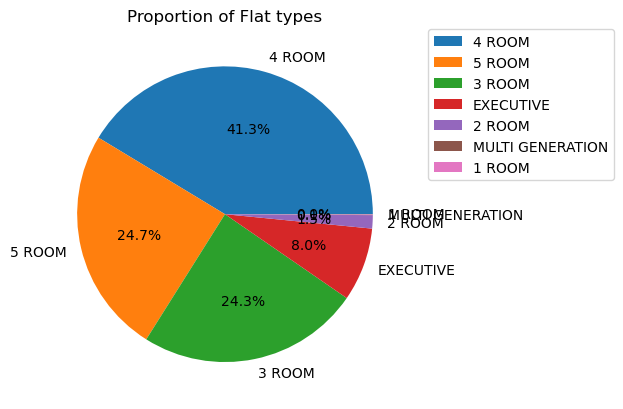

flat_type
4 ROOM              0.413430
5 ROOM              0.247219
3 ROOM              0.243339
EXECUTIVE           0.080449
2 ROOM              0.014567
MULTI GENERATION    0.000540
1 ROOM              0.000457
Name: proportion, dtype: float64

In [24]:
#Create pie chart to understand distribution of different flat types
category_counts =y_train.value_counts(normalize=True)

plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Proportion of Flat types')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


counts = y_train.value_counts(normalize=True)
counts

In [25]:
from sklearn.multiclass import OneVsRestClassifier


#create 20 evenly spaced integers from 1-100
lin_space=np.linspace(1, 100, 10)
lin_space=[int(x) for x in lin_space]

#determine parameters to test n_estimators, min_samples_leaf
params=[{'estimator__n_estimators': lin_space,
         'estimator__min_samples_leaf': [1,5,10,20]}]

scorer = {'Precision': make_scorer(precision_score,average='micro'),'Recall':make_scorer(recall_score,average='micro'),
              'fBeta': make_scorer(fbeta_score, beta=2,average='weighted')}

Model = OneVsRestClassifier(RandomForestClassifier(),verbose=10).fit(X_train, y_train)

y_pred =Model.predict(X_test)
y_score = Model.predict_proba(X_test)
classes =Model.classes_


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.3s finished


In [26]:
from sklearn.preprocessing import LabelBinarizer
#To one-hot-encode predicted values 
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

#credits:https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

(16064, 7)

In [39]:
#Create a numpy array of classes

classes = Model.classes_

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    class_of_interest = c
    # Prepare a dataframe to help with the plots
    df_aux = X_test.copy()
    #Create a dummy var if row in test dataset is the label of interest
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    #Get the probability score for the variable
    df_aux['prob'] = y_score[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Calculates the ROC Coordinates and plots the ROC Curves
    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, i],
        y_score[:, i],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",
        plot_chance_level=True,)
    display.ax_.legend(loc='upper right', prop={'size': 10}, bbox_to_anchor=(1, 1))
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="One-vs-Rest ROC curves:"+c)
    display.figure_.savefig(f'{plots_filepaths}_RFCA1_plot_{i+1}.png', bbox_inches='tight')
    fig = plt.gcf()  # Get the current figure
    fig.clf() 
#credits:https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

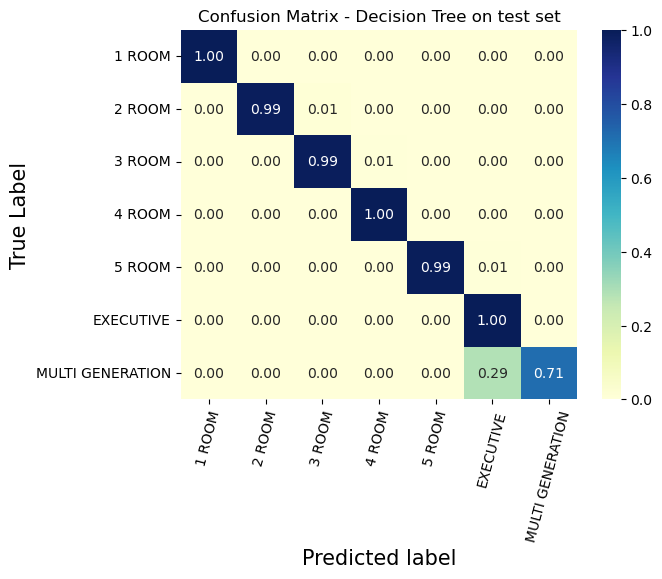

<Figure size 1000x700 with 0 Axes>

In [37]:
labels=classes
confusion_matrix = metrics.confusion_matrix(y_test,y_pred,normalize='true')#turn this into a dataframe
matrix_df = pd.DataFrame(confusion_matrix)#plot the result
ax = plt.axes()
#ns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, ax=ax, cmap="YlGnBu",annot=True, fmt=".2f")#set axis titles
ax.set_title('Confusion Matrix - Decision Tree on test set')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(list(labels), rotation = 0)
ax.set_xticklabels(list(labels), rotation = 75)
plt.show()

#https://freedium.cfd/https://towardsdatascience.com/how-to-implement-and-evaluate-decision-tree-classifiers-from-scikit-learn-36ef7f037a78